In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns; sns.set(font_scale=1.7)
import re
from datetime import datetime as dt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Cleaning and Exploration

In [3]:
## Reads in data
raw = pd.read_csv('Data/London_listings.csv')
raw.shape

(42646, 95)

In [4]:
records = raw.shape[0] 
features = raw.shape[1] 

In [5]:
## Columns to start with, no need for cleaning

starting_columns = ['accommodates', 
                    'bathrooms', 
                    'bedrooms', 
                    'beds',
                    'minimum_nights', 
                    'number_of_reviews',  
                    'review_scores_rating', 
                    'review_scores_accuracy', 
                    'review_scores_cleanliness', 
                    'review_scores_checkin', 
                    'review_scores_communication', 
                    'review_scores_location', 
                    'review_scores_value', 
                    'reviews_per_month']

In [6]:
## Use columns listed above, get a copy of raw data for future ML
data = raw[starting_columns].copy()

In [7]:
## Define a function to convert price related data from string to float
def convert_prices(col):
    p = raw[col].astype(str).str.strip('$')## 去掉美元符号＃＃
    New_Price = np.zeros(records)
    for i in range(records):
        try:
            New_Price[i] = np.float64(p[i]) 
        except ValueError:
            New_Price[i] = np.float64(p[i].replace(',',''))
    return New_Price

In [8]:
data['price'] = convert_prices('price')

data['cleaning_fee'] = convert_prices('cleaning_fee')

In [9]:
## Define a function to convert rate related data from string to float
def convert_rate(col):
    r = raw[col].astype(str).str.strip('%')
    New_Rate = np.zeros(records)
    for i in range(records):
        try:
            New_Rate[i] = np.float64(r[i])/ 100 
        except ValueError:
            pass
    return New_Rate

In [10]:
data['host_response_rate'] = convert_rate('host_response_rate')

data['host_acceptance_rate'] = convert_rate('host_acceptance_rate')

In [11]:
data['cleaning_fee'] = data['cleaning_fee'].fillna(0)
data['Total_Price'] = data['price'] + data['cleaning_fee']

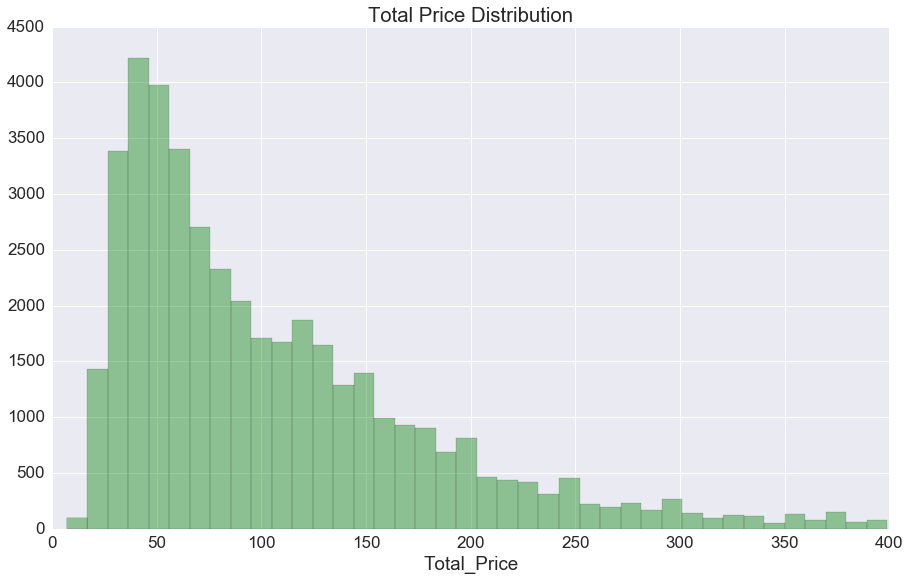

In [12]:
plt.figure(figsize = (15, 9))
sns.distplot(data.ix[data['Total_Price'] <400, 'Total_Price'],bins = 40, color = 'g',  kde= False)
plt.title('Total Price Distribution')

In [13]:
col = data.columns.tolist()
col_new = col[-1:]+ col[:-1]
data = data[col_new]

In [14]:
## Convert time related data from string to standard datetime format 
host_since_dt = []
for t in raw['host_since']:
    try:
        host_since_dt.append(dt.strptime(t, '%Y-%m-%d'))
    except TypeError:
        host_since_dt.append(dt(2016,6,2))   

In [15]:
scraped_date = dt(2016, 6, 2)
data['host_days'] = [ (scraped_date - time).days for time in  host_since_dt]

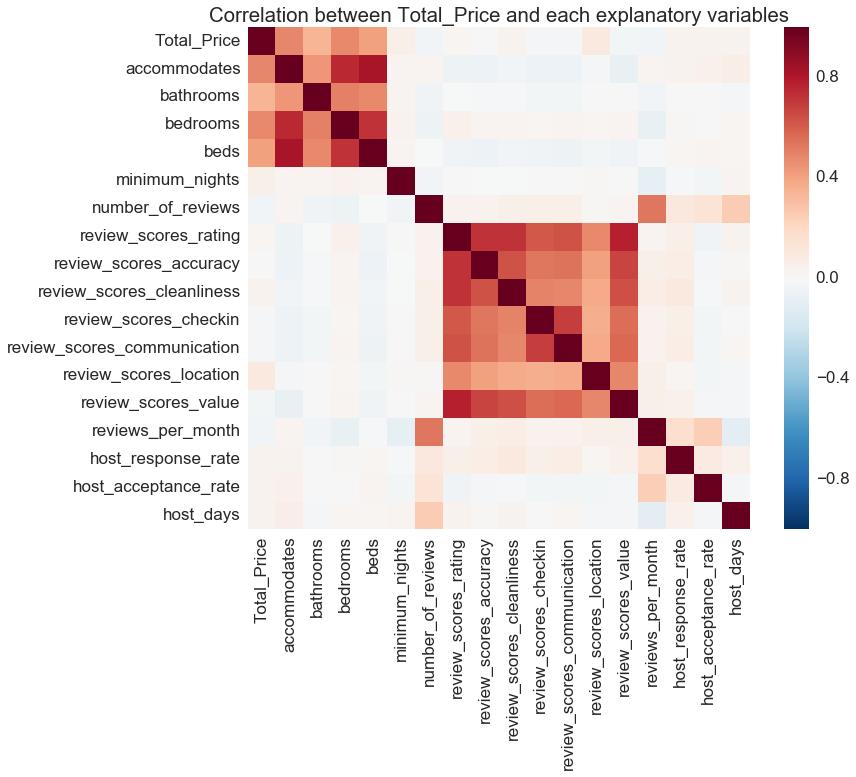

In [16]:
corr = data.drop(['price', 'cleaning_fee'], axis = 1).select_dtypes(include = ['float64', 'int64']).corr() ##
plt.figure(figsize=(12, 9))
sns.heatmap(corr, vmax=1, square=True)
ax = plt.axes()
ax.set_title('Correlation between Total_Price and each explanatory variables')

In [17]:
## List all the nominal features
dummies =['experiences_offered', 'neighbourhood_cleansed', 'room_type', 'bed_type']

In [18]:
data = pd.concat((data, raw[dummies]), axis = 1)

In [19]:
data_new = data[data['Total_Price'] <=400]

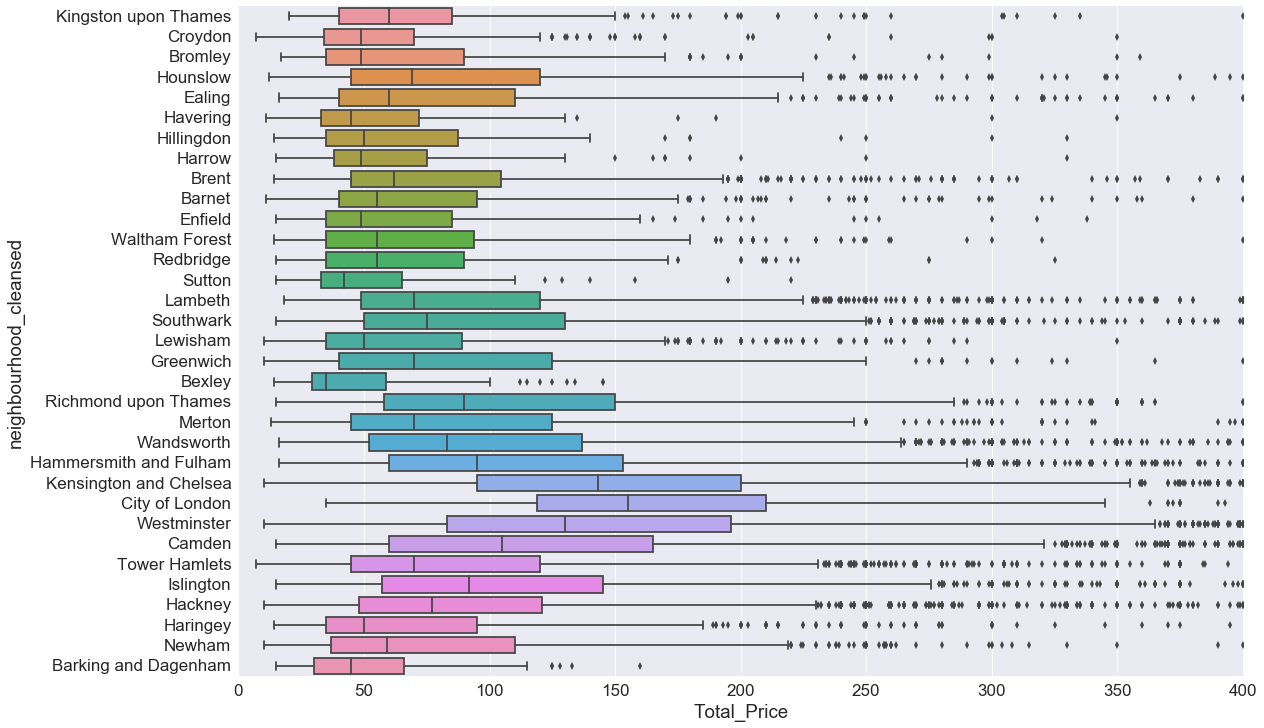

In [20]:
plt.figure(figsize = (18, 12))## 调整行和列 ##  
sns.boxplot(y = dummies[1], x = 'Total_Price',  data = data_new, )

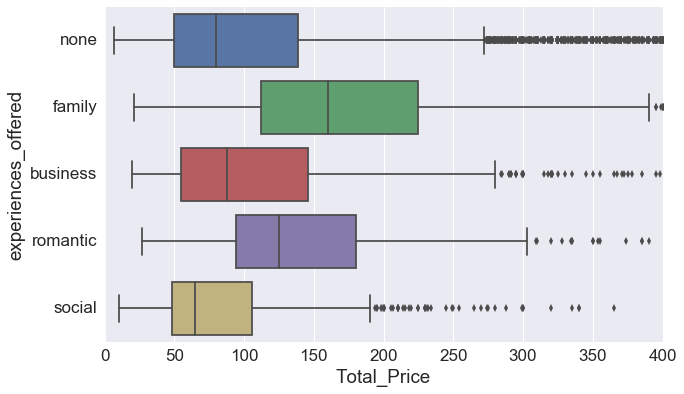

In [21]:
plt.figure(figsize = (10, 6))
sns.boxplot(y = dummies[0], x = 'Total_Price',  data = data_new, )

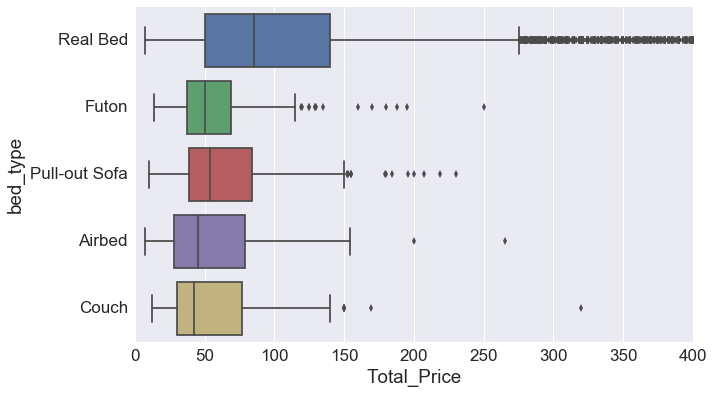

In [22]:
plt.figure(figsize = (10, 6))
sns.boxplot(y = dummies[3], x = 'Total_Price',  data = data_new, )

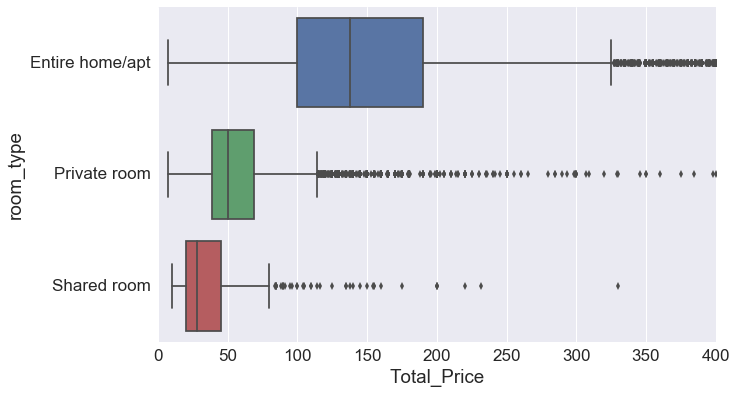

In [23]:
plt.figure(figsize = (10, 6))
sns.boxplot(y = dummies[2], x = 'Total_Price',  data = data_new, )

In [24]:
## List all the ordinal features
labels = ['host_response_time', 
          'host_is_superhost', 
          'host_has_profile_pic', 
          'host_identity_verified', 
          'instant_bookable', 
          'cancellation_policy', 
          'require_guest_profile_picture', 
          'require_guest_phone_verification']

In [25]:
data = pd.concat((data, raw[labels]), axis = 1)
data_new = data[data['Total_Price']<= 400]

In [26]:
data_new[labels] = data_new[labels].fillna('f')

In [27]:
X = data_new['Total_Price']
y = data_new[labels[1]]
colors = ['blue', 'red', 'green', 'yellow', 'm']
bins = np.linspace(0, 400, 10)
cat = y.unique()
n_cat = len(cat)

- Kernel Distribution in one plot http://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html

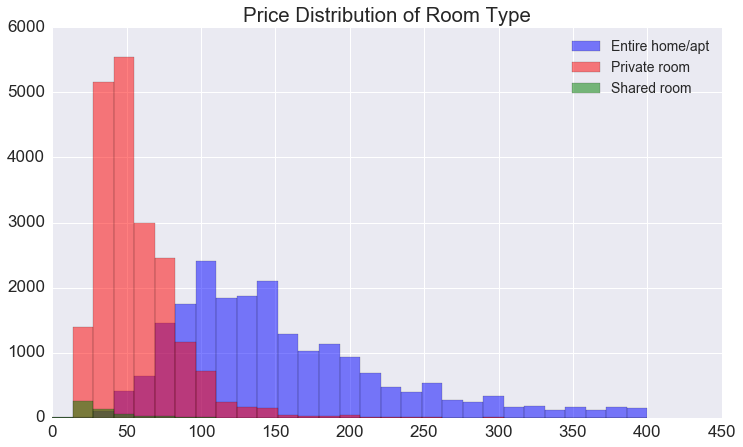

In [28]:
X = data_new['Total_Price']
y = data_new['room_type']
cat = y.unique()
n_cat = len(cat)
colors = ['blue', 'red', 'green', 'yellow', 'm']
bins = np.linspace(0, 400, 30)
fig, ax = plt.subplots(figsize = (12,7))
for lab, col in zip(cat, colors[:n_cat]):
    ax.hist(X[y == lab], color=col, label='%s' % lab, bins=bins, alpha=0.5,)
ylims = ax.get_ylim()
leg = ax.legend(loc='upper right', fancybox=True, fontsize=14)
leg.get_frame().set_alpha(0.5)
ax.set_ylim([0, max(ylims)+2])
ax.set_title('Price Distribution of Room Type')

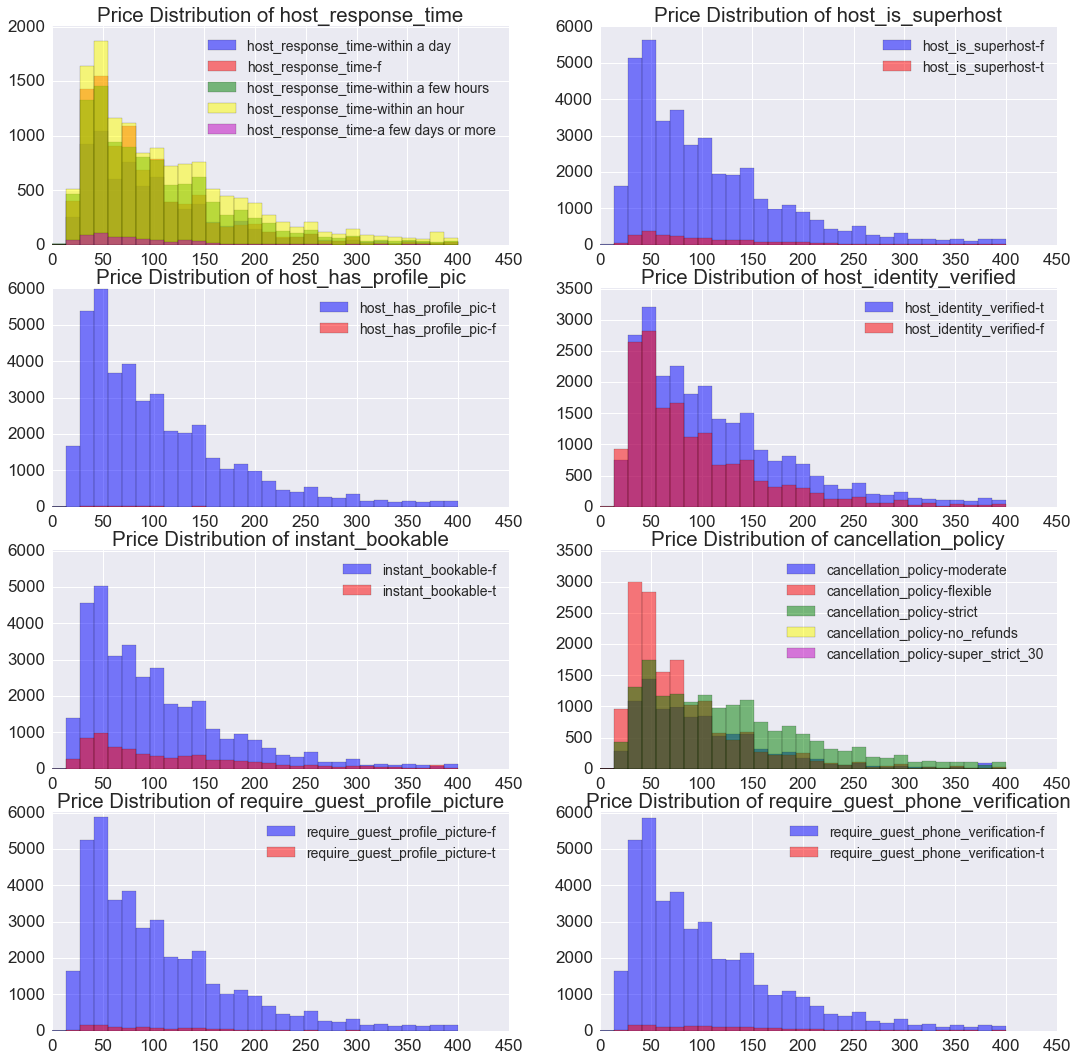

In [29]:
X = data_new['Total_Price']
colors = ['blue', 'red', 'green', 'yellow', 'm']
bins = np.linspace(0, 400, 30)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18,18))
for ax, cnt in zip(axes.ravel(), range(8)):  
    y = data_new[labels[cnt]]
    cat = y.unique()
    n_cat = len(cat)
    # plottling the histograms
    for lab, col in zip(cat, colors[:n_cat]):
        ax.hist(X[y == lab], color=col, label='%s-%s' % (labels[cnt], lab), bins=bins, alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=14)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_title('Price Distribution of %s' % labels[cnt])
 


In [30]:
data = data.drop(dummies, axis = 1)

In [31]:
## Define a function to convert nominal features into dummy variables
def add_dummies(col):
    return pd.get_dummies(raw[col], prefix = col)

In [32]:
## List all the nominal features
dummies =['experiences_offered', 'neighbourhood_cleansed', 'room_type', 'bed_type']

In [33]:
for col in dummies:
    col_dummies = add_dummies(col)
    data = pd.concat([data, col_dummies], axis =1 )

In [34]:
## Define a function to do the mapping for ordinal features
def encode_labels(col, mapping):
    return raw[col].map(mapping)

In [35]:
## Define mapping rules for ordinal features listed above, in order
mapping  = [{'within an hour': 0, 'within a few hours': 1, 'within a day': 2, 'a few days or more':3, np.nan: 4},
            {'f':0, 't':1},
            {'f':0, 't':1},
            {'f':0, 't':1},
            {'f':0, 't':1},
            {'strict': 1, 'super_strict_60':1, 'super_strict_30':1, 'no_refunds':1, 'moderate':2, 'flexible':3},
            {'f':0, 't':1},
            {'f':0, 't':1}]

In [36]:
for (col, mapping) in zip(labels, mapping):
    data[col] = encode_labels(col, mapping)

In [37]:
data = pd.concat((data, raw[['neighbourhood_cleansed', 'room_type']]), axis = 1)

In [38]:
data_new = data[data['Total_Price'] <= 400]
data_new = data_new.drop(['price', 'cleaning_fee'], axis =1)
data_new.head()

,Total_Price,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,...,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,neighbourhood_cleansed,room_type
0,175.0,6,1.0,3.0,4.0,4,6,87.0,8.0,9.0,...,1,0,0,0,0,0,0,1,Kingston upon Thames,Entire home/apt
1,72.0,3,1.0,1.0,2.0,1,5,96.0,10.0,10.0,...,0,1,0,0,0,0,0,1,Kingston upon Thames,Private room
2,82.0,2,1.0,0.0,1.0,5,4,95.0,10.0,10.0,...,1,0,0,0,0,0,0,1,Kingston upon Thames,Entire home/apt
3,145.0,3,1.0,1.0,2.0,1,14,88.0,10.0,8.0,...,1,0,0,0,0,0,0,1,Kingston upon Thames,Entire home/apt
4,45.0,2,1.0,1.0,1.0,1,3,93.0,10.0,10.0,...,0,1,0,0,0,1,0,0,Kingston upon Thames,Private room


In [39]:
%store data_new  ## 存在云上 ##

Stored 'data_new' (DataFrame)
